In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from torch import nn
import torch.nn.functional as F
import torch 
import pickle
import os
import random
import itertools
from scipy.stats import itemfreq
from tensorboardX import SummaryWriter



from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/home/demarkok/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [2]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [3]:
codones_dict = {}

def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq
    return [codones_dict.setdefault(cropped_seq[i:i+3], len(codones_dict)) for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [4]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [5]:
# all_codones = read_or_create(read_path='data/all_codones.pickle',
#                              producer= lambda: create_all_codones(seq_df))

all_codones = create_all_codones(seq_df)

In [8]:
######################

In [6]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = torch.zeros(batch_size, dtype=torch.long)
        target_batch = torch.zeros(batch_size, dtype=torch.long)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch, target_batch


def flatten(x):
    return [item for sublist in x for item in sublist]


def process_data(all_codones, batch_size, skip_window):
    single_gen = generate_sample(all_codones, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [7]:
freqs = np.array(np.bincount(flatten(all_codones)))

freqs = freqs.astype('float64')
freqs = freqs ** (3/4)
freqs = freqs / freqs.sum()


def sample_negative(size):
    return np.random.choice(len(freqs), size, p=freqs)

In [8]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

VOCAB_SIZE = 9424
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .05
NUM_TRAIN_STEPS = 100000
SKIP_STEP = 200
OUTPUT_PERIOD = 500



batch_gen = process_data(all_codones, BATCH_SIZE, SKIP_WINDOW)

In [9]:
######################

In [10]:
class SkipGramModel(nn.Module):
    """ Build the graph for word2vec model """

    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.embedding_central = nn.Embedding(vocab_size, embed_size)
        self.embedding_context = nn.Embedding(vocab_size, embed_size)

    def forward(self, central, context, negative):
        central = self.embedding_central(central)
        context = self.embedding_context(context)
        negative = self.embedding_context(negative)
        
        positive_loss = F.logsigmoid(torch.bmm(central.unsqueeze(1), context.unsqueeze(2))).mean()
        negative_loss = F.logsigmoid(torch.bmm(-negative, central.unsqueeze(2))).mean()
        return -(positive_loss + negative_loss)

In [11]:
######################

In [12]:
def train(model, batch_gen, num_train_steps, skip_step):
    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
    writer = SummaryWriter()
    for i, batch in itertools.islice(enumerate(batch_gen), skip_step, skip_step + num_train_steps):
        central, context = batch
        negative = torch.tensor(sample_negative(NUM_SAMPLED * BATCH_SIZE).reshape(BATCH_SIZE, NUM_SAMPLED))
        
        optimizer.zero_grad()
        loss = model(central, context, negative)
        loss.backward()
        optimizer.step()
        writer.add_scalar('Loss', loss, i)
        if i % OUTPUT_PERIOD == 0:
            print("iteration #{}. Loss = {}".format(i, loss))
    writer.close()

In [34]:
model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE)    
train(model, batch_gen, 10000, 0)

iteration #0. Loss = 8.234411239624023
iteration #200. Loss = 7.774445533752441
iteration #400. Loss = 8.42289924621582
iteration #600. Loss = 7.006721496582031
iteration #800. Loss = 8.56158447265625
iteration #1000. Loss = 8.553232192993164
iteration #1200. Loss = 7.3996357917785645
iteration #1400. Loss = 8.13987922668457
iteration #1600. Loss = 8.282341003417969
iteration #1800. Loss = 8.233194351196289
iteration #2000. Loss = 7.970799446105957
iteration #2200. Loss = 8.54956340789795
iteration #2400. Loss = 8.474409103393555
iteration #2600. Loss = 8.183063507080078
iteration #2800. Loss = 7.358214378356934
iteration #3000. Loss = 7.663330554962158
iteration #3200. Loss = 7.369484901428223
iteration #3400. Loss = 7.341753005981445
iteration #3600. Loss = 7.479693412780762
iteration #3800. Loss = 8.837509155273438
iteration #4000. Loss = 7.361857891082764
iteration #4200. Loss = 7.849420547485352
iteration #4400. Loss = 7.53826904296875
iteration #4600. Loss = 8.54080867767334
iter

In [35]:
final_embed_matrix = model.embedding_central.weight.detach()
print(final_embed_matrix)

tensor([[-0.3956,  0.1435,  0.3914,  ..., -0.4389, -0.7764,  0.1793],
        [-0.4001,  1.5264,  0.2517,  ...,  1.0583,  0.7861,  1.1197],
        [ 1.2830,  0.6959,  0.6678,  ..., -0.5115, -2.2996,  1.1973],
        ...,
        [ 0.2937, -0.2077,  2.4434,  ...,  0.1061, -0.8310,  0.6706],
        [ 0.4916,  1.3576, -0.7917,  ...,  0.5174,  0.6592, -1.6026],
        [ 1.5756, -0.7987, -0.2501,  ...,  2.2922,  1.2522, -0.1399]])


In [15]:
######################

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [ ]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(codones_dict, key=codones_dict.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

In [ ]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

In [ ]:
plot_tsne_df(tsne_df)

In [21]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [22]:
######################

In [23]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [24]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

saving data/all_acid_dicts.pickle


In [25]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,MAF,2.166667,116.482633,18.666667,147.133333
1,SAE,-0.833333,95.756400,15.333333,105.333333
2,DVL,1.500000,109.125367,19.000000,139.266667
3,KEY,-2.900000,140.153200,22.333333,166.866667
4,DRR,-4.166667,142.486267,22.666667,152.633333


In [26]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,MAF,2.166667,116.482633,18.666667,147.133333,2.399720,10.965635
1,SAE,-0.833333,95.756400,15.333333,105.333333,-17.173643,-29.135303
2,DVL,1.500000,109.125367,19.000000,139.266667,-18.113457,-23.866198
3,KEY,-2.900000,140.153200,22.333333,166.866667,-1.724143,-26.274704
4,DRR,-4.166667,142.486267,22.666667,152.633333,8.483065,-23.777246


In [27]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

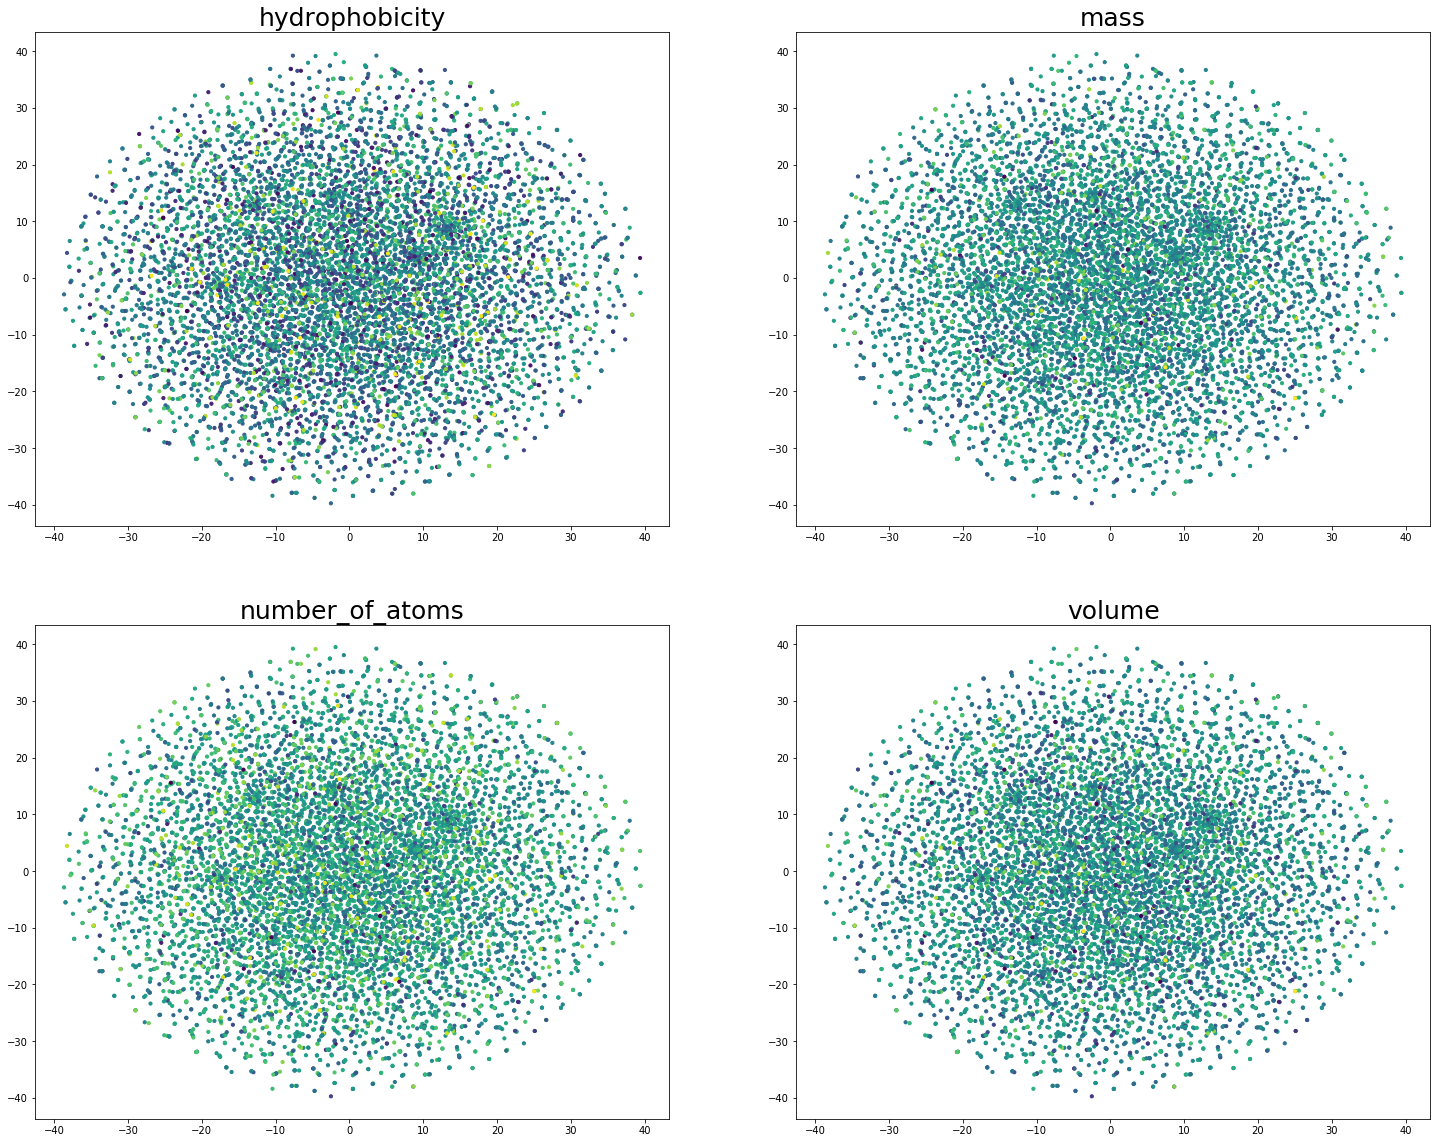

In [28]:
plot_embedding_properties(final_df)

In [28]:
######################

In [29]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

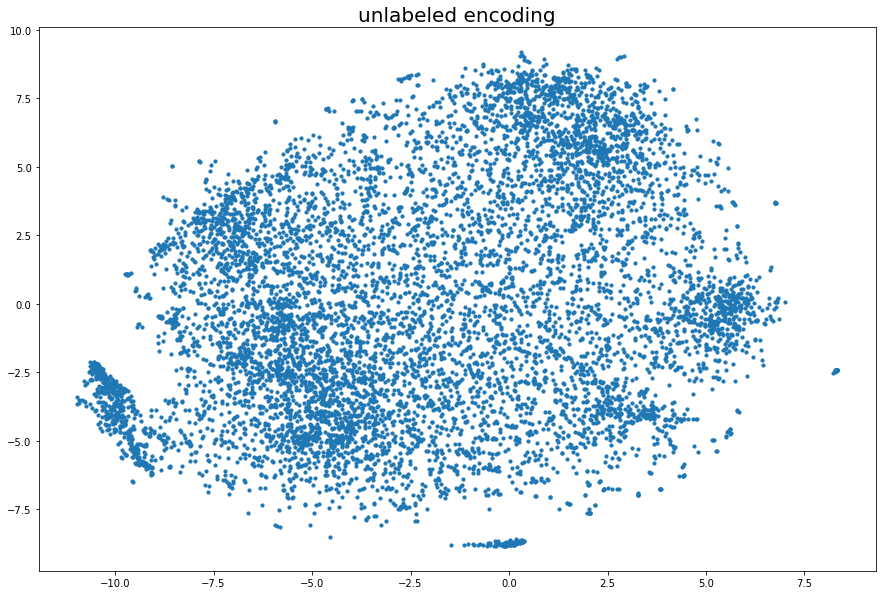

In [30]:
plot_tsne_df(gensim_tsne_df)

In [32]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

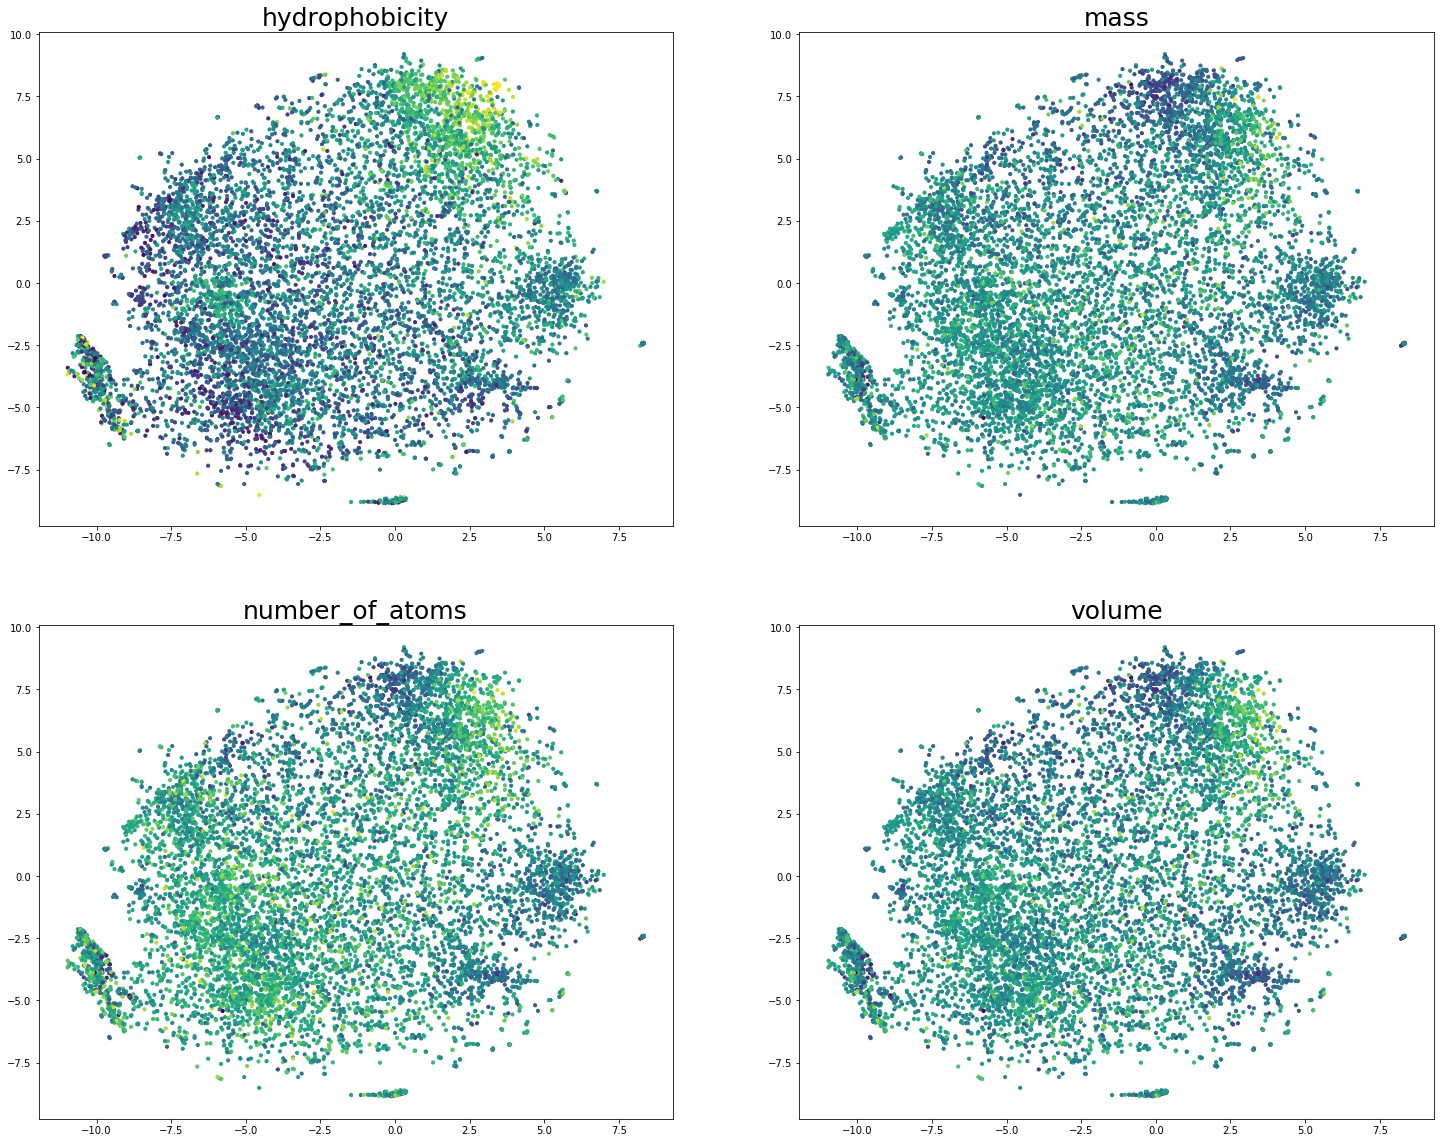

In [33]:
plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [ ]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59